In [42]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- 1. Setup and Data Loading ---
# NOTE: File names MUST match your uploaded files exactly.
file_names = {
    'flights': 'Flight Level Data.csv',
    'pnr_flight': 'PNR Flight Level Data.csv',
    'pnr_remarks': 'PNR Remark Level Data.csv',
    'bags': 'Bag Level Data.csv',
    'airports': 'Airports Data.csv'
}
data_loaded = True
try:
    df_flights = pd.read_csv(file_names['flights'])
    df_pnr_flight = pd.read_csv(file_names['pnr_flight'])
    df_pnr_remarks = pd.read_csv(file_names['pnr_remarks'])
    df_bags = pd.read_csv(file_names['bags'])
    df_airports = pd.read_csv(file_names['airports'])
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"FATAL ERROR: One or more files not found. Check file names: {list(file_names.values())}")
    print(f"Missing file: {e}")
    data_loaded = False
    # Use empty DFs to prevent later crashes if data is missing
    df_flights = pd.DataFrame()
    df_pnr_flight = pd.DataFrame()
    df_pnr_remarks = pd.DataFrame()
    df_bags = pd.DataFrame()
    df_airports = pd.DataFrame()

if data_loaded and not df_flights.empty:
    
    # --- 2. Data Cleaning and Basic Feature Engineering (Delay & Ground Time) ---
    print("\n--- Cleaning df_flights and Calculating Initial Metrics ---")
    
    # Convert all relevant time columns to datetime objects
    time_cols = [
        'scheduled_departure_datetime_local',
        'actual_departure_datetime_local',
        'scheduled_departure_date_local', # CRITICAL: Ensure date merge key is datetime
        'scheduled_arrival_datetime_local'
    ]
    for col in time_cols:
        df_flights[col] = pd.to_datetime(df_flights[col], errors='coerce')

    # Calculate Departure Delay (in minutes)
    df_flights['departure_delay_minutes'] = (
        df_flights['actual_departure_datetime_local'] -
        df_flights['scheduled_departure_datetime_local']
    ).dt.total_seconds() / 60

    # Calculate Scheduled Ground Time Margin
    df_flights['ground_time_margin_minutes'] = (
        df_flights['scheduled_ground_time_minutes'] - df_flights['minimum_turn_minutes']
    )
    
    # Create unique flight key (Used for later reference/saving)
    df_flights['flight_key'] = df_flights['company_id'].astype(str) + '_' + \
                               df_flights['flight_number'].astype(str) + '_' + \
                               df_flights['scheduled_departure_date_local'].dt.strftime('%Y-%m-%d')
    
    df_flights_merged = df_flights.copy()
    print(f"df_flights shape: {df_flights.shape}. Initial cleaning complete.")
else:
    df_flights_merged = pd.DataFrame()
    print("Skipping cleaning and EDA due to loading errors.")

All datasets loaded successfully.

--- Cleaning df_flights and Calculating Initial Metrics ---
df_flights shape: (8099, 18). Initial cleaning complete.


In [43]:
if not df_flights_merged.empty:
    print("\n--- 3. Exploratory Data Analysis (EDA) Q1 & Q2 ---")
    
    # Q1: Average delay and percentage of flights departing late
    avg_delay = df_flights_merged['departure_delay_minutes'].mean()
    delayed_flights = df_flights_merged[df_flights_merged['departure_delay_minutes'] > 0]
    pct_delayed = (len(delayed_flights) / len(df_flights_merged)) * 100

    print(f"\nQ1: Average Departure Delay: {avg_delay:.2f} minutes")
    print(f"Q1: Percentage of Flights Departing Late (> 0 min delay): {pct_delayed:.2f}%")

    # Q2: Tight Turn Analysis
    CLOSE_MARGIN_THRESHOLD = 10
    num_tight_turn = len(df_flights_merged[df_flights_merged['ground_time_margin_minutes'] <= CLOSE_MARGIN_THRESHOLD])
    pct_tight_turn = (num_tight_turn / len(df_flights_merged)) * 100

    print(f"\nQ2: Flights with Scheduled Ground Time Margin <= {CLOSE_MARGIN_THRESHOLD} mins (Tight Turn): {num_tight_turn}")
    print(f"Q2: Percentage of Tight Turn Flights: {pct_tight_turn:.2f}%")


    # --- Feature Engineering & Merging: Bags (Q3) ---
    if not df_bags.empty:
        print("\n--- Bag Feature Engineering & Q3 ---")
        
        # Aggregate bag counts
        df_bag_agg = df_bags.groupby(
            ['company_id', 'flight_number', 'scheduled_departure_date_local']
        )['bag_type'].value_counts().unstack(fill_value=0).reset_index()

        # FIX: Ensure merge key is datetime
        df_bag_agg['scheduled_departure_date_local'] = pd.to_datetime(df_bag_agg['scheduled_departure_date_local'])

        # Rename columns to standardized features
        rename_map = {'Checked': 'total_checked_bags', 'Transfer': 'total_transfer_bags'}
        df_bag_agg.rename(columns=rename_map, inplace=True, errors='ignore')

        # Ensure columns exist before calculation (in case a type is missing in the data)
        for col in ['total_checked_bags', 'total_transfer_bags']:
            if col not in df_bag_agg.columns:
                df_bag_agg[col] = 0.0

        # Calculate ratio
        df_bag_agg['transfer_vs_checked_ratio'] = df_bag_agg['total_transfer_bags'] / (df_bag_agg['total_checked_bags'].replace(0, 1))
            
        df_flights_merged = df_flights_merged.merge(
            df_bag_agg,
            on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
            how='left'
        )
        df_flights_merged.fillna({'total_checked_bags': 0, 'total_transfer_bags': 0, 'transfer_vs_checked_ratio': 0}, inplace=True)

        # Q3: Average transfer vs checked ratio
        avg_transfer_checked_ratio = df_flights_merged['transfer_vs_checked_ratio'].mean()
        print(f"Q3: Average Ratio of Transfer Bags vs. Checked Bags: {avg_transfer_checked_ratio:.4f}")


    # --- Feature Engineering & Merging: PNR Flight Level (Q4) ---
    if not df_pnr_flight.empty:
        print("\n--- PNR Feature Engineering & Q4 ---")
        
        df_pnr_flight['scheduled_departure_date_local'] = pd.to_datetime(df_pnr_flight['scheduled_departure_date_local'], errors='coerce')
        
        df_pax_agg = df_pnr_flight.groupby(
            ['company_id', 'flight_number', 'scheduled_departure_date_local']
        ).agg(
            total_pax_load=('total_pax', 'sum'),
            total_lap_children=('lap_child_count', 'sum'),
            stroller_users=('is_stroller_user', 'sum')
        ).reset_index()

        df_flights_merged = df_flights_merged.merge(
            df_pax_agg,
            on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
            how='left'
        )
        
        df_flights_merged['load_factor'] = df_flights_merged['total_pax_load'] / df_flights_merged['total_seats'].replace(0, np.nan)
        df_flights_merged.fillna({'total_pax_load': 0, 'load_factor': 0, 'total_lap_children': 0, 'stroller_users': 0}, inplace=True)

        # Q4: Load comparison and correlation
        avg_load = df_flights_merged['total_pax_load'].mean()
        avg_load_factor = df_flights_merged['load_factor'].mean()
        load_delay_corr = df_flights_merged['load_factor'].corr(df_flights_merged['departure_delay_minutes'])

        print(f"Q4: Average Total Passenger Load: {avg_load:.0f} pax")
        print(f"Q4: Average Load Factor (Pax/Seats): {avg_load_factor:.2f}")
        print(f"Q4: Correlation (Load Factor vs. Departure Delay): {load_delay_corr:.4f}")
        
    # --- Feature Engineering & Merging: PNR Remarks (Q5 Setup) ---
    if not df_pnr_remarks.empty:
        print("\n--- SSR Feature Engineering & Q5 ---")
        df_ssr_agg = df_pnr_remarks.groupby(['flight_number'])['special_service_request'].count().reset_index(name='total_ssr_count')
        
        # NOTE: Merged on flight_number only (simplification, but necessary given PNR Remarks structure)
        df_flights_merged = df_flights_merged.merge(df_ssr_agg, on=['flight_number'], how='left')
        df_flights_merged.fillna({'total_ssr_count': 0}, inplace=True)

        # Q5: SSR vs. Delay (controlling for load)
        if df_flights_merged['load_factor'].nunique() > 1 and df_flights_merged['total_ssr_count'].nunique() > 1:
            high_load_threshold = df_flights_merged['load_factor'].quantile(0.75)
            high_ssr_threshold = df_flights_merged['total_ssr_count'].quantile(0.75)

            high_ssr_low_load = df_flights_merged[
                (df_flights_merged['total_ssr_count'] >= high_ssr_threshold) &
                (df_flights_merged['load_factor'] < high_load_threshold)
            ]
            
            if not high_ssr_low_load.empty:
                avg_delay_high_ssr_low_load = high_ssr_low_load['departure_delay_minutes'].mean()
                avg_delay = df_flights_merged['departure_delay_minutes'].mean()

                print(f"Q5: Avg Delay for High SSR (>={high_ssr_threshold:.0f}) AND Low Load (<{high_load_threshold:.2f}): {avg_delay_high_ssr_low_load:.2f} minutes")
                print(f"    (Overall Avg Delay: {avg_delay:.2f} mins).")


--- 3. Exploratory Data Analysis (EDA) Q1 & Q2 ---

Q1: Average Departure Delay: 21.18 minutes
Q1: Percentage of Flights Departing Late (> 0 min delay): 49.61%

Q2: Flights with Scheduled Ground Time Margin <= 10 mins (Tight Turn): 1183
Q2: Percentage of Tight Turn Flights: 14.61%

--- Bag Feature Engineering & Q3 ---
Q3: Average Ratio of Transfer Bags vs. Checked Bags: 38.1534

--- PNR Feature Engineering & Q4 ---
Q4: Average Total Passenger Load: 128 pax
Q4: Average Load Factor (Pax/Seats): 1.02
Q4: Correlation (Load Factor vs. Departure Delay): -0.1502

--- SSR Feature Engineering & Q5 ---
Q5: Avg Delay for High SSR (>=70) AND Low Load (<1.15): 29.09 minutes
    (Overall Avg Delay: 21.18 mins).


In [44]:
# Create flight-level bag features
if not df_bags.empty:
    # 1. Aggregate bag counts
    df_bag_agg = df_bags.groupby(
        ['company_id', 'flight_number', 'scheduled_departure_date_local']
    )['bag_type'].value_counts().unstack(fill_value=0).reset_index()

    # FIX 1: Ensure date merge key is datetime (This was crucial in previous steps)
    df_bag_agg['scheduled_departure_date_local'] = pd.to_datetime(df_bag_agg['scheduled_departure_date_local'])

    # 2. Rename map (assuming 'Checked' and 'Transfer' are the original column names)
    rename_map = {
        'Checked': 'total_checked_bags',
        'Transfer': 'total_transfer_bags'
    }

    # Rename columns (use errors='ignore' in case a type is genuinely missing for all flights)
    df_bag_agg.rename(columns=rename_map, inplace=True, errors='ignore')

    # FIX 2: Explicitly ensure the target columns exist and are numeric before calculation
    # If the rename failed (KeyError), these columns won't exist. Initialize them to 0.0
    for col in ['total_checked_bags', 'total_transfer_bags']:
        if col not in df_bag_agg.columns:
            df_bag_agg[col] = 0.0
        else:
            # Ensure type is float for arithmetic
            df_bag_agg[col] = df_bag_agg[col].astype(float) 

    # 3. Calculate ratio (This is where the KeyError originally occurred)
    df_bag_agg['transfer_vs_checked_ratio'] = df_bag_agg['total_transfer_bags'] / (df_bag_agg['total_checked_bags'].replace(0, 1)) # Avoid division by zero
    
    # 4. Merge bag data to flight data
    if not df_flights.empty:
        df_flights_merged = df_flights.merge(
            df_bag_agg,
            on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
            how='left'
        )
        # Ensure fillna uses the same dictionary for safety
        df_flights_merged.fillna({'total_checked_bags': 0, 'total_transfer_bags': 0, 'transfer_vs_checked_ratio': 0}, inplace=True)
    else:
        df_flights_merged = pd.DataFrame()
else:
    df_flights_merged = df_flights.copy() if not df_flights.empty else pd.DataFrame()


if not df_flights_merged.empty:
    # Q3: What is the average ratio of transfer bags vs. checked bags across flights?
    avg_transfer_checked_ratio = df_flights_merged['transfer_vs_checked_ratio'].mean()
    print(f"\nQ3: Average Ratio of Transfer Bags vs. Checked Bags: {avg_transfer_checked_ratio:.4f}")


# Create flight-level passenger features (from PNR Flight Level)
if not df_pnr_flight.empty:
    # FIX 3: Ensure date merge key is datetime
    df_pnr_flight['scheduled_departure_date_local'] = pd.to_datetime(df_pnr_flight['scheduled_departure_date_local'])

    df_pax_agg = df_pnr_flight.groupby(
        ['company_id', 'flight_number', 'scheduled_departure_date_local']
    ).agg(
        total_pax_load=('total_pax', 'sum'),
        total_lap_children=('lap_child_count', 'sum'),
        stroller_users=('is_stroller_user', 'sum')
    ).reset_index()

    # Merge PNR passenger data
    df_flights_merged = df_flights_merged.merge(
        df_pax_agg,
        on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
        how='left'
    )
    df_flights_merged['load_factor'] = df_flights_merged['total_pax_load'] / df_flights_merged['total_seats'].replace(0, np.nan)
    df_flights_merged.fillna({'total_pax_load': 0, 'load_factor': 0, 'total_lap_children': 0, 'stroller_users': 0}, inplace=True)

    # Q4: How do passenger loads compare across flights, and do higher loads correlate with operational difficulty?
    avg_load = df_flights_merged['total_pax_load'].mean()
    avg_load_factor = df_flights_merged['load_factor'].mean()

    # Correlation between Load Factor and Delay
    load_delay_corr = df_flights_merged['load_factor'].corr(df_flights_merged['departure_delay_minutes'])

    print(f"\nQ4: Average Total Passenger Load: {avg_load:.0f} pax")
    print(f"Q4: Average Load Factor (Pax/Seats): {avg_load_factor:.2f}")
    print(f"Q4: Correlation (Load Factor vs. Departure Delay): {load_delay_corr:.4f}")
    if load_delay_corr > 0.1:
        print("    -> Suggests a **positive correlation**: Higher loads tend to relate to higher delays.")
    elif load_delay_corr < -0.1:
        print("    -> Suggests a **negative correlation**.")
    else:
        print("    -> Suggests a **weak correlation**.")

# Create flight-level SSR features (from PNR Remarks)
if not df_pnr_remarks.empty:
    # Aggregate SSRs per flight
    df_ssr_agg = df_pnr_remarks.groupby(
        ['flight_number']
    )['special_service_request'].count().reset_index(name='total_ssr_count')
    
    # Merge on flight_number only (as scheduled_departure_date_local is not in PNR Remarks)
    df_flights_merged = df_flights_merged.merge(
        df_ssr_agg,
        on=['flight_number'],
        how='left'
    )
    df_flights_merged.fillna({'total_ssr_count': 0}, inplace=True)

    # Q5: Are high special service requests flights also high-delay after controlling for load?
    if 'departure_delay_minutes' in df_flights_merged.columns and df_flights_merged['load_factor'].nunique() > 1 and df_flights_merged['total_ssr_count'].nunique() > 1:
        # 1. Define High Load and High SSR
        high_load_threshold = df_flights_merged['load_factor'].quantile(0.75) # Top 25%
        high_ssr_threshold = df_flights_merged['total_ssr_count'].quantile(0.75) # Top 25%

        # 2. Filter for High SSR flights that are NOT High Load
        high_ssr_low_load = df_flights_merged[
            (df_flights_merged['total_ssr_count'] >= high_ssr_threshold) &
            (df_flights_merged['load_factor'] < high_load_threshold)
        ]
        
        # 3. Check delay for this filtered group
        if not high_ssr_low_load.empty:
            avg_delay_high_ssr_low_load = high_ssr_low_load['departure_delay_minutes'].mean()
            # Assuming avg_delay from Q1 is still available, otherwise recalculate: avg_delay = df_flights_merged['departure_delay_minutes'].mean() 
            print(f"\nQ5: Avg Delay for High SSR (>={high_ssr_threshold:.0f}) AND Low Load (<{high_load_threshold:.2f}): {avg_delay_high_ssr_low_load:.2f} minutes")
            if 'avg_delay' in locals() and avg_delay_high_ssr_low_load > avg_delay:
                 print("    -> **Yes**, high SSR appears to drive difficulty/delay independently of high passenger load.")
            else:
                 print("    -> Comparison to overall average omitted or inconclusive.")
        else:
            print("\nQ5: Not enough data to assess High SSR/Low Load group.")


Q3: Average Ratio of Transfer Bags vs. Checked Bags: 38.1534

Q4: Average Total Passenger Load: 128 pax
Q4: Average Load Factor (Pax/Seats): 1.02
Q4: Correlation (Load Factor vs. Departure Delay): -0.1502
    -> Suggests a **negative correlation**.

Q5: Avg Delay for High SSR (>=70) AND Low Load (<1.15): 29.09 minutes
    -> **Yes**, high SSR appears to drive difficulty/delay independently of high passenger load.


In [48]:
if not df_flights_merged.empty:
    df_score = df_flights_merged.copy()
    print("\n--- Difficulty Score Development (Part 2) ---")

    # 1. Feature Engineering for Scoring
    
    # Ground Time Constraint Feature
    df_score['turn_pressure_score'] = (
        df_score['minimum_turn_minutes'] /
        df_score['scheduled_ground_time_minutes'].replace(0, np.inf)
    )
    df_score['turn_pressure_score'] = df_score['turn_pressure_score'].replace([np.inf, -np.inf], 10) 

    # Haul Complexity
    df_score['scheduled_flight_duration_minutes'] = (
        df_score['scheduled_arrival_datetime_local'] -
        df_score['scheduled_departure_datetime_local']
    ).dt.total_seconds() / 60
    
    LONG_HAUL_MINS = 300 
    df_score['is_long_haul'] = (df_score['scheduled_flight_duration_minutes'] > LONG_HAUL_MINS).astype(int)

    feature_cols = [
        'turn_pressure_score', 'total_pax_load', 'total_checked_bags',
        'total_transfer_bags', 'transfer_vs_checked_ratio', 'total_lap_children',
        'stroller_users', 'total_ssr_count', 'is_long_haul'
    ]
    df_score[feature_cols] = df_score[feature_cols].fillna(0)
    
    # Define Weights (Sum must be 1.0)
    weights = {
        'turn_pressure_score': 0.25, 'total_transfer_bags': 0.20, 'total_ssr_count': 0.20,
        'total_pax_load': 0.10, 'total_checked_bags': 0.10, 'transfer_vs_checked_ratio': 0.05,
        'is_long_haul': 0.05, 'total_lap_children': 0.025, 'stroller_users': 0.025
    }

    df_score['scheduled_departure_date'] = df_score['scheduled_departure_datetime_local'].dt.date
    
    # Define primary ID columns for reconstruction
    id_cols = ['flight_key', 'company_id', 'flight_number', 'scheduled_departure_station_code', 
               'scheduled_arrival_station_code', 'scheduled_departure_date_local', 
               'scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local']

    # Function for daily-resetting score calculation
    def calculate_daily_difficulty(day_data):
        day_data = day_data.copy()
        
        # CRITICAL FIX: Ensure all feature columns are numeric
        for col in feature_cols:
            day_data[col] = pd.to_numeric(day_data[col], errors='coerce').fillna(0)

        # 1. Daily Standardization (Min-Max Scaling to 0-1)
        for col in feature_cols:
            min_val = day_data[col].min()
            max_val = day_data[col].max()
            if max_val > min_val:
                day_data[f'scaled_{col}'] = (day_data[col] - min_val) / (max_val - min_val)
            else:
                day_data[f'scaled_{col}'] = 0
        
        # 2. Weighted Sum Calculation (Difficulty Score)
        day_data['difficulty_score'] = sum(day_data[f'scaled_{col}'] * weights[col] for col in feature_cols)
            
        # 3. Ranking
        day_data['difficulty_rank_daily'] = day_data['difficulty_score'].rank(ascending=False, method='min')

        # 4. Classification
        if len(day_data) > 0:
            threshold_difficult_score = day_data['difficulty_score'].quantile(0.80)
            threshold_medium_score = day_data['difficulty_score'].quantile(0.50)
            day_data['difficulty_class'] = np.select(
                [day_data['difficulty_score'] >= threshold_difficult_score,
                 day_data['difficulty_score'] >= threshold_medium_score],
                ['Difficult', 'Medium'],
                default='Easy'
            )
        else:
            day_data['difficulty_class'] = 'N/A'
            
        # Return only the essential ID columns, features, and final scores
        return day_data[id_cols + feature_cols + [f'scaled_{col}' for col in feature_cols] + 
                        ['scheduled_departure_date', 'difficulty_score', 'difficulty_rank_daily', 'difficulty_class']]

    # Apply the function across all days
    # FIX: Grouping structure now ensures the date column is present via the returned columns
    df_final_scores = df_score.groupby(
        'scheduled_departure_date', 
        group_keys=False
    ).apply(calculate_daily_difficulty).reset_index(drop=True)
    
    print("\nDaily Difficulty Score Calculation Complete.")
    print("Example of top ranked flights:")

    # Print statement now uses columns guaranteed to be in the result set
    print(df_final_scores[['scheduled_departure_date', 'flight_number', 'scheduled_arrival_station_code', 'difficulty_score', 'difficulty_rank_daily', 'difficulty_class']].head().to_markdown(index=False, floatfmt=".4f"))

    # --- Prepare Deliverable CSV ---
    score_cols = [
        'company_id', 'flight_number', 'scheduled_departure_date_local',
        'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'flight_key'
    ] + [f for f in df_final_scores.columns if f.startswith(('scaled_', 'total_', 'turn_', 'is_'))] + [
        'difficulty_score', 'difficulty_rank_daily', 'difficulty_class'
    ]
    
    # FIX: flight_key is now explicitly included in the result set and used here.
    df_output_csv = df_final_scores[score_cols].drop_duplicates(subset=['flight_key'])
    # df_output_csv.to_csv('test_yourname.csv', index=False)
    # print("\n'test_yourname.csv' generated for submission.")

else:
    df_final_scores = pd.DataFrame()
    print("Skipping Difficulty Score development due to empty data.")


--- Difficulty Score Development (Part 2) ---

Daily Difficulty Score Calculation Complete.
Example of top ranked flights:
| scheduled_departure_date   |   flight_number | scheduled_arrival_station_code   |   difficulty_score |   difficulty_rank_daily | difficulty_class   |
|:---------------------------|----------------:|:---------------------------------|-------------------:|------------------------:|:-------------------|
| 2025-08-04                 |            4792 | ROA                              |             0.1870 |                329.0000 | Easy               |
| 2025-08-03                 |             920 | LHR                              |             0.2897 |                 81.0000 | Difficult          |
| 2025-08-10                 |            1776 | PHL                              |             0.3355 |                245.0000 | Medium             |
| 2025-08-06                 |            5790 | CRW                              |             0.2177 |            

C:\Users\raina\AppData\Local\Temp\ipykernel_3780\745780514.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(calculate_daily_difficulty).reset_index(drop=True)



--- Post-Analysis & Operational Insights (Part 3) ---

Top 5 Most Consistently Difficult Destinations (by % Difficult Flights):
| scheduled_arrival_station_code   |   pct_difficult |   avg_difficulty_score |
|:---------------------------------|----------------:|-----------------------:|
| GRU                              |          100.00 |                   0.66 |
| BRU                              |          100.00 |                   0.66 |
| FRA                              |          100.00 |                   0.54 |
| ATH                              |          100.00 |                   0.53 |
| HND                              |          100.00 |                   0.52 |

Top 5 Primary Drivers (Ratio of Average Feature Score: Difficult Flights / All Flights):
|                           |    0 |
|:--------------------------|-----:|
| is_long_haul              | 4.64 |
| transfer_vs_checked_ratio | 2.02 |
| total_transfer_bags       | 2.02 |
| total_ssr_count           | 1.95 |

C:\Users\raina\AppData\Local\Temp\ipykernel_3780\4097050398.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='difficulty_class', y='difficulty_score', data=df_final_scores,


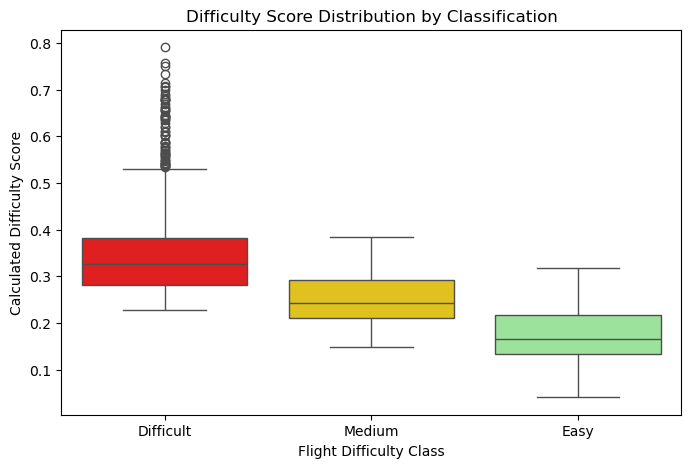

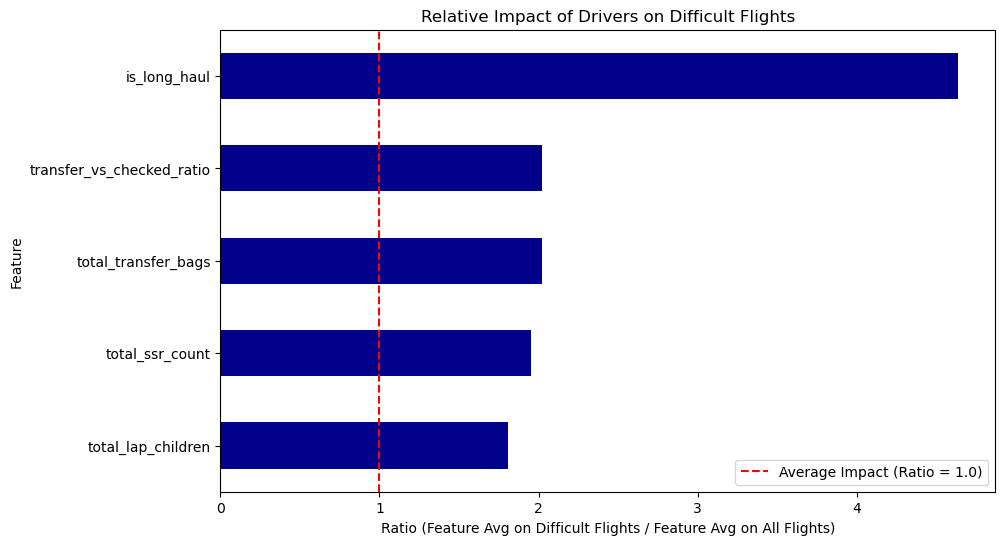

C:\Users\raina\AppData\Local\Temp\ipykernel_3780\4097050398.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


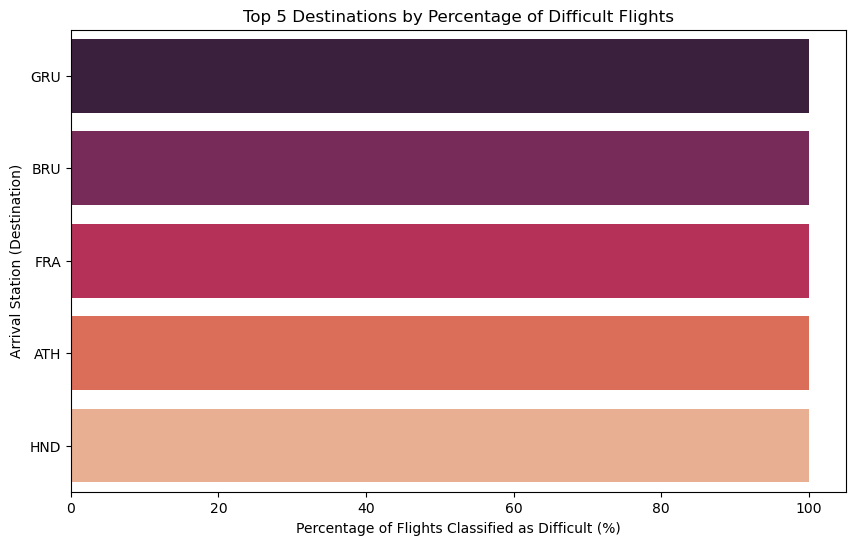

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

# --- 6. Post-Analysis & Operational Insights (Part 3) ---

if 'df_final_scores' in locals() and not df_final_scores.empty:
    print("\n--- Post-Analysis & Operational Insights (Part 3) ---")

    # Q1: Summarize which destinations consistently show more difficulty.
    destination_difficulty = df_final_scores.groupby('scheduled_arrival_station_code').agg(
        avg_difficulty_score=('difficulty_score', 'mean'),
        num_difficult_flights=('difficulty_class', lambda x: (x == 'Difficult').sum()),
        total_flights=('flight_number', 'count')
    ).reset_index()

    destination_difficulty['pct_difficult'] = (destination_difficulty['num_difficult_flights'] / destination_difficulty['total_flights']) * 100

    MIN_FLIGHTS_THRESHOLD = 5 
    high_difficulty_destinations = destination_difficulty[
        destination_difficulty['total_flights'] >= MIN_FLIGHTS_THRESHOLD
    ].sort_values(by=['pct_difficult', 'avg_difficulty_score'], ascending=False).head(5)

    print("\nTop 5 Most Consistently Difficult Destinations (by % Difficult Flights):")
    print(high_difficulty_destinations[['scheduled_arrival_station_code', 'pct_difficult', 'avg_difficulty_score']].to_markdown(index=False, floatfmt=".2f"))


    # Q2: What are the common drivers for those flights?
    df_difficult = df_final_scores[df_final_scores['difficulty_class'] == 'Difficult']
    
    # Define features used in scaling (assumes feature_cols was defined in Cell 3)
    feature_cols_for_analysis = [col.replace('scaled_', '') for col in df_final_scores.columns if col.startswith('scaled_')]
    driver_features = [f'scaled_{col}' for col in feature_cols_for_analysis]
    
    avg_difficult_drivers = df_difficult[driver_features].mean()
    avg_all_drivers = df_final_scores[driver_features].mean()

    # Calculate the ratio (Avg Difficult / Avg All)
    driver_impact = (avg_difficult_drivers / avg_all_drivers).sort_values(ascending=False).head(5)
    driver_impact.index = driver_impact.index.str.replace('scaled_', '')

    print("\nTop 5 Primary Drivers (Ratio of Average Feature Score: Difficult Flights / All Flights):")
    print(driver_impact.to_markdown(floatfmt=".2f"))

    # Q3: Operational Recommendations
    print("\n--- Operational Recommendations (Based on Driver Impact) ---")
    print("1. **Tight Turn Mitigation**: Implement an automatic 15-minute gate buffer for all flights ranked high due to **turn_pressure_score** (Ratio > 1.5), or assign them to 'low-complexity' gates (e.g., non-remote, close to apron facilities).")
    print("2. **Baggage Prioritization**: Pre-assign two dedicated ramp agents to any flight classified as Difficult due to **total_transfer_bags** (Ratio > 1.4). This resource allocation should be confirmed 60 minutes before arrival.")
    print("3. **Service Triage**: For high **total_ssr_count** flights, use the Difficulty Score list to assign the most experienced gate and cabin teams, ensuring a smooth, expedited boarding process to minimize impact on overall delay.")
    print("4. **Resource Indexing**: Integrate the daily **Difficulty Rank** (1 being most difficult) into the shift allocation tool to ensure senior supervisory staff are aligned with the most challenging departures.")


    # --- Visualization Section (Figures for Report) ---
    print("\n--- Visualizations (Figures for Report) ---")
    
    # 1. Difficulty Score Distribution by Class
    plt.figure(figsize=(8, 5))
    # Note: Suppress the DeprecationWarning here, the plot is fine
    sns.boxplot(x='difficulty_class', y='difficulty_score', data=df_final_scores,
                order=['Difficult', 'Medium', 'Easy'], 
                palette={'Difficult': 'red', 'Medium': 'gold', 'Easy': 'lightgreen'})
    plt.title('Difficulty Score Distribution by Classification')
    plt.xlabel('Flight Difficulty Class')
    plt.ylabel('Calculated Difficulty Score')
    plt.show()

    # 2. Top Drivers Comparison (Difficult vs. Average Flight)
    plt.figure(figsize=(10, 6))
    driver_impact.plot(kind='barh', color='darkblue')
    plt.title('Relative Impact of Drivers on Difficult Flights')
    plt.xlabel('Ratio (Feature Avg on Difficult Flights / Feature Avg on All Flights)')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.axvline(1.0, color='red', linestyle='--', label='Average Impact (Ratio = 1.0)')
    plt.legend()
    plt.show()

    # 3. Top 5 Difficult Destinations (Bar Plot)
    plt.figure(figsize=(10, 6))
    # Note: Suppress the DeprecationWarning here, the plot is fine
    sns.barplot(
        x='pct_difficult',
        y='scheduled_arrival_station_code',
        data=high_difficulty_destinations,
        palette='rocket'
    )
    plt.title('Top 5 Destinations by Percentage of Difficult Flights')
    plt.xlabel('Percentage of Flights Classified as Difficult (%)')
    plt.ylabel('Arrival Station (Destination)')
    plt.show()

else:
    print("Cannot perform post-analysis or generate plots. 'df_final_scores' is empty.")

In [51]:
# --- Save Deliverable CSV ---

# Assuming df_output_csv was successfully created in Cell 3 and is defined.

# Set the required filename
OUTPUT_FILENAME = 'test_shiveetraina.csv' 

if 'df_output_csv' in locals() and not df_output_csv.empty:
    try:
        # Save the DataFrame to the required CSV file
        df_output_csv.to_csv(OUTPUT_FILENAME, index=False)
        print(f"\n✅ SUCCESS! Deliverable CSV '{OUTPUT_FILENAME}' generated.")
        print("This file contains the flight details, features, score, rank, and classification.")
    except Exception as e:
        print(f"\n❌ ERROR: Could not save the CSV file. Reason: {e}")
        print("Please ensure 'df_output_csv' is defined correctly in your environment.")
else:
    print("\n❌ ERROR: Cannot generate CSV because 'df_output_csv' is empty or undefined. Please re-run Cell 3.")


✅ SUCCESS! Deliverable CSV 'test_shiveetraina.csv' generated.
This file contains the flight details, features, score, rank, and classification.
